# Importing necessary libraries and creating data tables

In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from IPython.display import display, Markdown
import seaborn as sns
from src.make_db import create_movies_db
pd.options.display.float_format="{:.2f}".format

create_movies_db()
con = sqlite3.connect('data/movies.db')

imdb_title_principals table created successfully....
imdb_name_basic table created successfully....
imdb_title_crew table created successfully....
imdb_title_ratings table created successfully....
imdb_title_basics table created successfully....
imdb_title_akas table created successfully....
tn_movie_budgets table created successfully....
tmdb_movies table created successfully....
bom_movie_gross table created successfully....
rotten_tomatoes_critic_reviews table created successfully....
rotten_tomatoes_movies table created successfully....
Inserting data into the imdb_title_crew table....
Inserting data into the tmdb_movies table....
Inserting data into the imdb_title_akas table....
Inserting data into the imdb_title_ratings table....
Inserting data into the imdb_name_basics table....
Inserting data into the rotten_tomatoes_movies table....
Inserting data into the rotten_tomatoes_critic_reviews table....
Inserting data into the imdb_title_basics table....
Inserting data into the tn_mo

# Creating and Formatting the Dataframe

Joins tn_movie_budgets with imdb_title_basics on the title column.  Cleans numerical data and sets it to integer typre. 

Creates total gross column combining domestic and foreign gross, net profit column subtracting budget from total gross, and return on investment dividing total gross by production budget.

Limits data to only films released from Jan 1, 2010 to Jan 1, 2019.

Creates year and month columns from release date column.

Creates two columns grouped by budget.  One with fewer bins than the other.  Film Size being indicative of our reccomended budget catagories.

Drops two rows with erroneous reportings of gross.



In [17]:
df = pd.read_sql('''SELECT distinct id, release_date, movie, production_budget, domestic_gross, worldwide_gross, genres  
                    FROM tn_movie_budgets AS tn
                     JOIN imdb_title_basics AS imdb
                 ON tn.movie = imdb.primary_title
                    ;''', con)
#Joins tn_movie_budgets with imdb_title_basics on the title column.

df.genres = df.genres.str.split(',') #this performs the split on the same column of data
df = df.explode('genres') #this explodes the newly created column and saves it to a new df


df.drop_duplicates(subset=['genres', 'movie'], keep='last', inplace = True)
df['production_budget'] = df['production_budget'].str.replace(',', '', regex = True)
df['production_budget'] = df['production_budget'].str.replace('$', '', regex = True).astype(int)
df['domestic_gross'] = df['domestic_gross'].str.replace(',', '', regex = True)
df['domestic_gross'] = df['domestic_gross'].str.replace('$', '', regex = True).astype(int)
df['worldwide_gross'] = df['worldwide_gross'].str.replace(',', '', regex = True)
df['worldwide_gross'] = df['worldwide_gross'].str.replace('$', '', regex = True).astype(int)

##Cleans numerical data and sets it to integer typre. 

df.release_date = pd.to_datetime(df.release_date)

df['total_gross'] = df['worldwide_gross'] + df['domestic_gross']  
#Creates total gross column combining domestic and foreign gross
df['net_profit'] = df['total_gross'] - df['production_budget']
#Creates net profit column subtracting budget from total gross,
df['return_on_investment'] = df['net_profit'] / df['production_budget']
# Createsreturn on investment dividing total gross by production budget
df = df[(df['release_date'] >= '2010-01-01') & (df['release_date'] <= '2019-01-01')]
#Limits data to only films released from Jan 1, 2010 to Jan 1, 2019.
month = df['release_date'].apply(lambda x: x.month).astype(int)
year = df['release_date'].apply(lambda x: x.year).astype(int)
df['month'] = month
df['year'] = year
#Creates year and month columns from release date column.
df.loc[df.production_budget>0, 'film_size']='0-5m$'
df.loc[df.production_budget>5000000, 'film_size']='5m-45m$'
df.loc[df.production_budget>45000000, 'film_size']='45m$+'
#Creates film size column based on our 4-45m reccomendation
df.groupby('production_budget')
df['budget_bins'] = pd.cut(df['production_budget'], [0, 1000000, 5000000, 10000000, 15000000, 20000000, 50000000, 100000000, 200000000, 400000000, 500000000])
bud_size = pd.cut(df['production_budget'], [0, 5000000, 45000000, 500000000])
grouped_bins =  df.groupby(df.budget_bins)['production_budget'].agg(['count'])
#Creates 
df = df.drop([361, 3496], axis=0)
df.sort_values(by='return_on_investment', ascending=False)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,genres,total_gross,net_profit,return_on_investment,month,year,film_size,budget_bins
3178,12,2012-01-06,The Devil Inside,1000000,53262945,101759490,Horror,155022435,154022435,154.02,1,2012,0-5m$,"(0, 1000000]"
3093,63,2011-04-01,Insidious,1500000,54009150,99870886,Thriller,153880036,152380036,101.59,4,2011,0-5m$,"(1000000, 5000000]"
3093,63,2011-04-01,Insidious,1500000,54009150,99870886,Mystery,153880036,152380036,101.59,4,2011,0-5m$,"(1000000, 5000000]"
3093,63,2011-04-01,Insidious,1500000,54009150,99870886,Horror,153880036,152380036,101.59,4,2011,0-5m$,"(1000000, 5000000]"
3179,14,2015-04-17,Unfriended,1000000,32789645,64364198,Horror,97153843,96153843,96.15,4,2015,0-5m$,"(0, 1000000]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,47,2016-05-06,Code of Honor,8000000,0,0,Action,0,-8000000,-1.00,5,2016,5m-45m$,"(5000000, 10000000]"
2285,59,2013-12-31,Re-Kill,9500000,0,0,Horror,0,-9500000,-1.00,12,2013,5m-45m$,"(5000000, 10000000]"
2285,59,2013-12-31,Re-Kill,9500000,0,0,Action,0,-9500000,-1.00,12,2013,5m-45m$,"(5000000, 10000000]"
2274,47,2015-05-19,Into the Grizzly Maze,10000000,0,0,Drama,0,-10000000,-1.00,5,2015,5m-45m$,"(5000000, 10000000]"


# Budget v Net Profit Scatter and Regression Line

predicting 

Text(0.5, 0, 'Production Budget (Hundreds of Millions USD)')

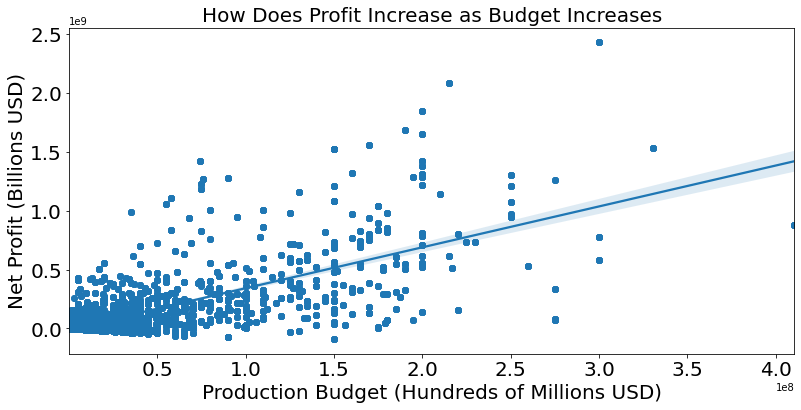

In [3]:
plot_one_fig, plot_one_ax = plt.subplots(figsize=(13,6))
plot_one_ax.scatter(df['production_budget'], df['net_profit'])
sns.regplot (data = df, x='production_budget', y= 'net_profit')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('How Does Profit Increase as Budget Increases', fontsize=20)
plt.ylabel('Net Profit (Billions USD)', fontsize=20)
plt.xlabel('Production Budget (Hundreds of Millions USD)', fontsize=20)

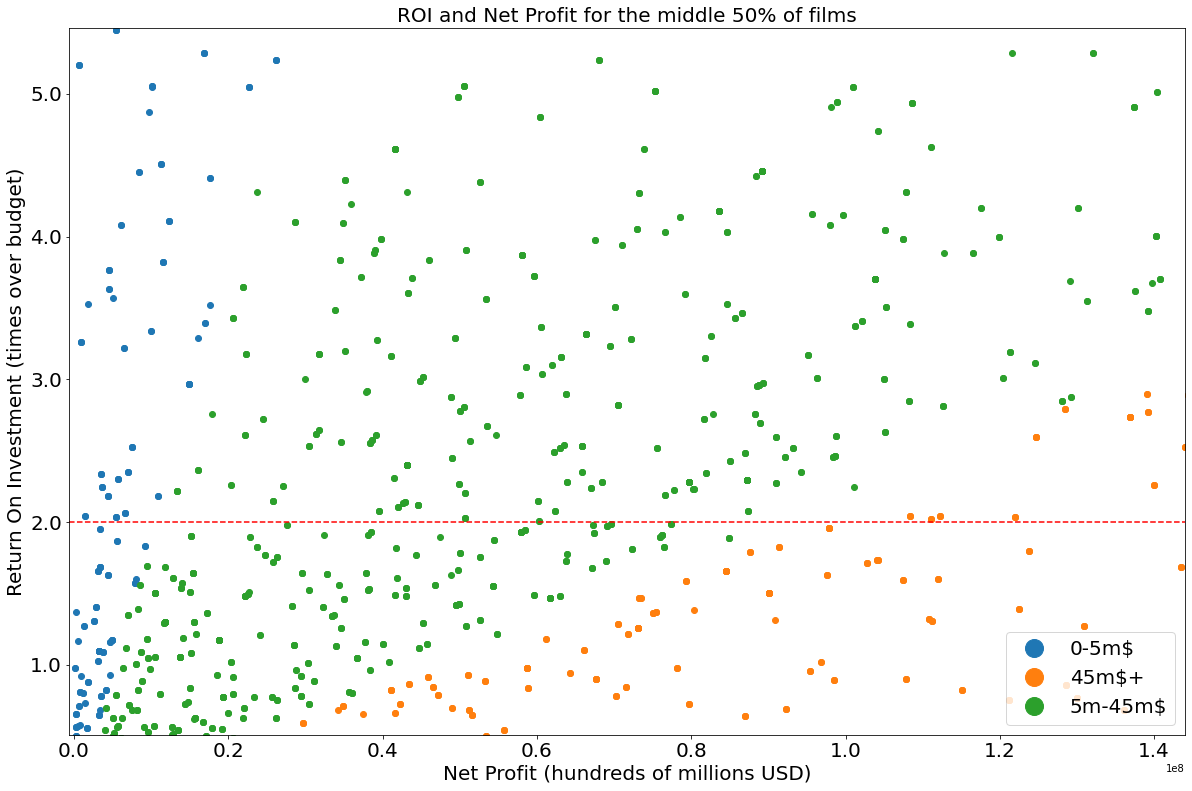

In [4]:
plot_three_fig, plot_three_ax = plt.subplots(figsize=(20,13))
df = df.sort_values(by = "return_on_investment", ascending=False)
groups = df.groupby("film_size")
for name, group in groups:

    plt.plot(group['net_profit'],  group['return_on_investment'], marker='o', linestyle="", label=name)
plt.legend(loc='lower right', fontsize =20, markerscale= 3)
plt.yticks([.5, 1, 2, 3, 4, 5], fontsize=20)
plt.ylim(.51, 5.46)
plt.title('ROI and Net Profit for the middle 50% of films', fontsize=20)
plt.ylabel('Return On Investment (times over budget)', fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Net Profit (hundreds of millions USD)', fontsize=20)
plt.xlim(-650000.00, 143991357.00)
plt.axhline(y=2, color='r', linestyle='--')
plt.ticklabel_format(useOffset=False, style='sci')

In [5]:
df.describe()

,id,production_budget,domestic_gross,worldwide_gross,total_gross,net_profit,return_on_investment,month,year
count,4914.00,4914.00,4914.00,4914.00,4914.00,4914.00,4914.00,4914.00,4914.00
mean,51.63,39380070.05,48375829.69,122423591.64,170799421.33,131419351.28,3.75,6.99,2013.86
std,28.58,52678728.64,80359509.45,220856980.40,297993596.85,258400638.46,8.78,3.48,2.40
min,1.00,1400.00,0.00,0.00,0.00,-89057484.00,-1.00,1.00,2010.00
25%,27.00,5000000.00,455104.25,2507164.50,3721393.00,-663624.50,-0.49,4.00,2012.00
50%,52.00,20000000.00,18704596.00,37228116.00,58483589.00,33586653.00,1.56,7.00,2014.00
75%,76.00,50000000.00,57744720.00,131237787.00,189989586.00,143991357.00,4.45,10.00,2016.00
max,100.00,410600000.00,700059566.00,2048134200.00,2726949682.00,2426949682.00,154.02,12.00,2018.00


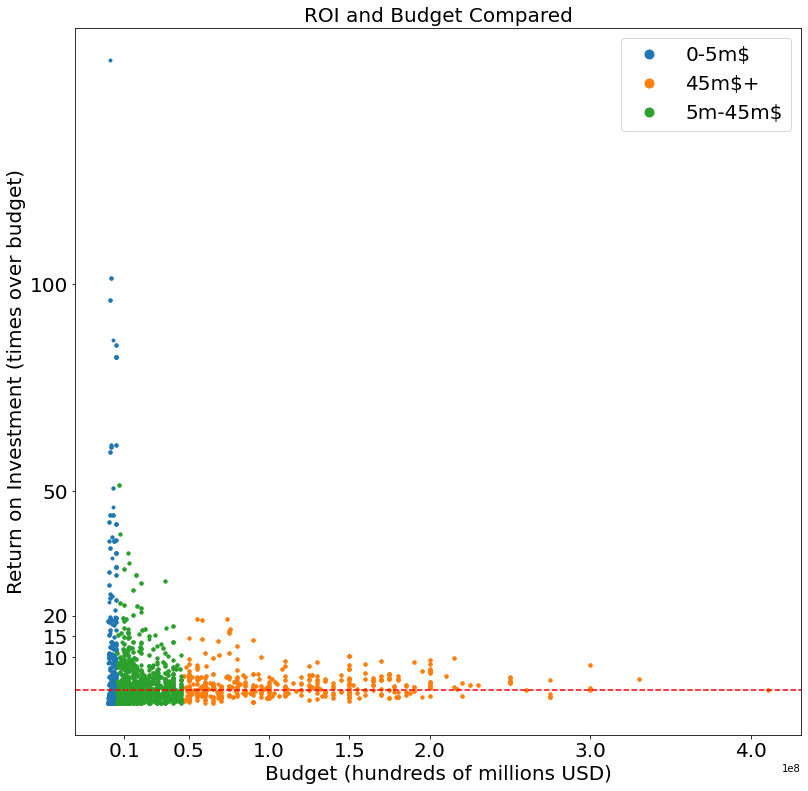

In [6]:
plot_three_fig, plot_three_ax = plt.subplots(figsize=(13,13))
#plot_three_ax.scatter(df['production_budget'], df['return_on_investment'])
for name, group in groups:
    plt.plot(group['production_budget'],  group['return_on_investment'], marker='.', linestyle="", label=name)
plt.yticks([10, 15, 20, 50, 100], fontsize=20)
plt.legend(loc='upper right', fontsize =20, markerscale= 3)
plt.title('ROI and Budget Compared', fontsize=20)
plt.ylabel('Return on Investment (times over budget)', fontsize=20)
plt.xlabel('Budget (hundreds of millions USD)', fontsize=20)
plt.xticks([10000000, 50000000, 100000000, 150000000, 200000000, 300000000, 400000000], fontsize =20)
plt.axhline(y=2, color='r', linestyle='--')
plt.ticklabel_format(useOffset=False, style='sci')

In [7]:
def probability(df, num):
    probabilities = {}
    bins = df.budget_bins.unique()
    for bin_ in bins:       
        frame = df[(df.budget_bins == bin_) & (df.return_on_investment >= num)]
        total_in_budget_bin = grouped_bins.loc[bin_]['count']
        number_with_high_ri = frame.shape[0]
        probability = number_with_high_ri/total_in_budget_bin
        probabilities[bin_] = probability
    probabilities = dict(sorted(probabilities.items(), key=lambda x: x[0]))
    return probabilities
probabilities = probability(df, 2)
probabilities4 = probability(df, 4)


NameError: name 'probabilities5' is not defined

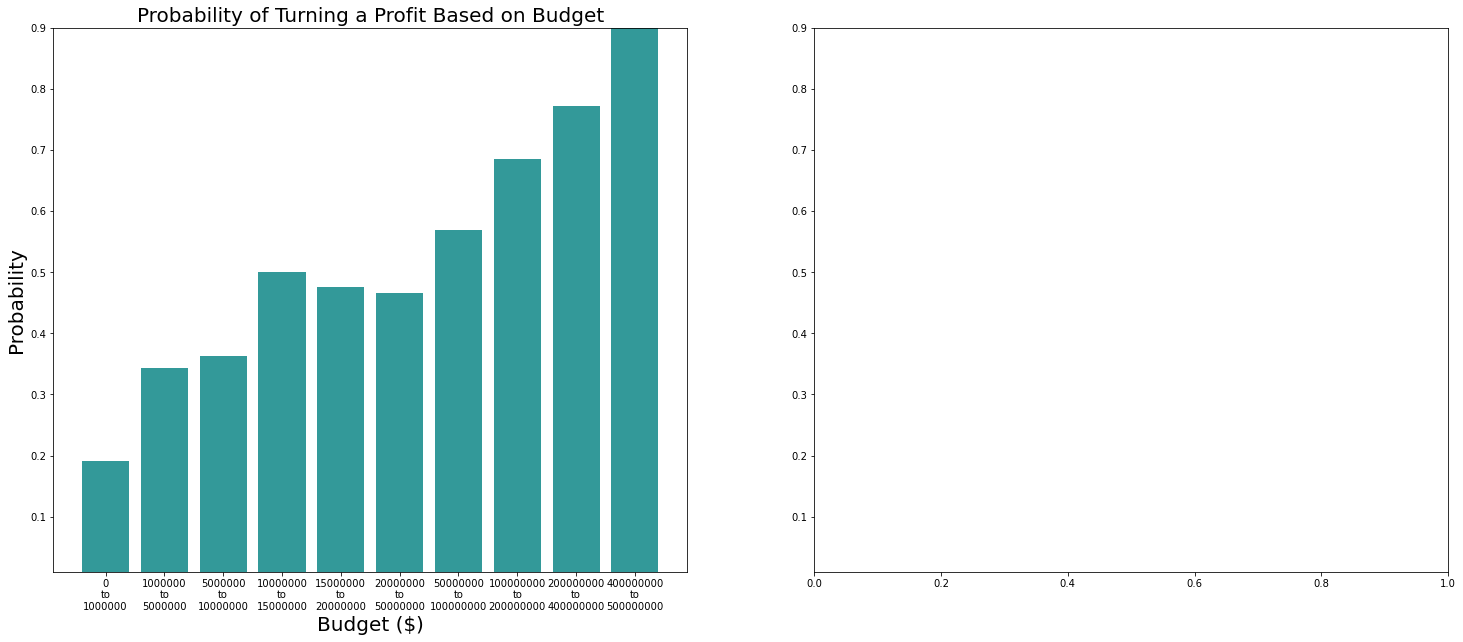

In [8]:
#sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(25,10))
plt.ylim(.01,.9)
ax[0].bar([f'{_.left}\nto\n{_.right}' for _ in probabilities], probabilities.values(), color='teal', alpha=.8)
ax[0].set_ylim(.01,.9)
ax[0].set_ylabel('Probability', fontsize=20)
ax[0].set_xlabel('Budget ($)', fontsize=20)
ax[0].set_title('Probability of Turning a Profit Based on Budget', fontsize=20)
ax[1].bar([f'{_.left}\nto\n{_.right}' for _ in probabilities5], probabilities4.values(), color='slateblue', alpha=.8)
ax[1].set_ylim(.01,.9)
ax[1].set_title('Probability of Returning 4x ROI Based on Budget', fontsize=20)
ax[1].set_ylabel('Probability', fontsize=20)
ax[1].set_xlabel('Budget ($)', fontsize=20)


In [ ]:
small_budget = df[(df['production_budget'] >= 5000000) & (df['production_budget'] <= 45000000)]
big_budget = df[(df['production_budget'] >= 45000000)]
mid_budget = df[df['film_size'] == '5m-45m$']

In [ ]:
def genre_wins(df):
    good_genres = df.genres.value_counts().index[:8].tolist()
    df = df[df.genres.isin(good_genres)]
    genre_wins = df[df.return_on_investment >= 2]
    return genre_wins
def genre_loss(df):
    good_genres = df.genres.value_counts().index[:8].tolist()
    df = df[df.genres.isin(good_genres)]
    genre_wins = df[df.return_on_investment <= 2]
    return genre_wins
big_wins=genre_wins(big_budget)
small_wins=genre_wins(small_budget)
mid_wins=genre_wins(mid_budget)
big_loss=genre_loss(big_budget)
small_loss=genre_loss(small_budget)
mid_loss=genre_loss(mid_budget)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(big_wins.groupby('month').count().id.index, big_wins.groupby('month').count().id, color='darkorange') 
ax.set_xlabel('Month', fontsize= 20, c='firebrick')
ax.set_ylabel('Number of Films with ROI > 2', fontsize = 20, c='firebrick')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], fontsize=20)
plt.yticks(fontsize=20)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_title('What Month are Profitable Films with 45m-400m$ Budget Released', color='firebrick', fontsize=20)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(mid_wins.groupby('month').count().id.index, mid_wins.groupby('month').count().id, color='darkgreen') 
ax.set_xlabel('Month', fontsize=20, c='navy')
ax.set_ylabel('Number of Films with ROI > 2', fontsize=20, c='navy')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], fontsize=20)
plt.yticks(fontsize=20)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_title('What Month are Profitable Films with 5m-45m$ Budget Released', color='navy', fontsize=20)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(mid_wins.groupby('genres').count().id.index, mid_wins.groupby('genres').count().id, color='darkgreen') 
ax.set_xlabel('Genres', fontsize=20, color='navy')
ax.set_ylabel('Number of Films with ROI > 2', fontsize=20, color='navy')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_title('What genres are successful 5-45m$ films', color='navy', fontsize=20)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(big_wins.groupby('genres').count().id.index, big_wins.groupby('genres').count().id, color='darkorange') 
ax.set_xlabel('Genres', fontsize=20, c='firebrick')
ax.set_ylabel('Number of Films with ROI > 2', fontsize=20, c='firebrick')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_title('What genres are successful 45m-400m$ films', color='firebrick', fontsize=20)